# **Protocolo de codificación super densa** (Qiskit vs Pennylane)
*Universidad Nacional Autónoma de México*
### Creado por: **Sebastián González Juárez**

In [1]:
!pip install pennylane --quiet
!pip install qiskit --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.7 MB/s eta 0:00:00


In [5]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.quantum_info import Statevector
import pennylane as qml
from pennylane import numpy as qnp

##**Qiskit**

In [4]:
def pretty_ket(sv):
    # sv: qiskit.quantum_info.Statevector con 2 qubits (A,B)
    # Imprime amplitudes en orden |00>,|01>,|10>,|11>
    basis = ["00","01","10","11"]
    amps = [complex(a) for a in sv.data]
    for b, a in zip(basis, amps):
        if abs(a) > 1e-12:
            print(f"|{b}>: {a.real:+.6f}{a.imag:+.6f}j")
    print()

# 1) Par de Bell
qc_bell = QuantumCircuit(2, 2)
qc_bell.h(0)
qc_bell.cx(0,1)
sv_bell = Statevector.from_instruction(qc_bell)
print("Estado tras preparar Bell |Φ+>:")
pretty_ket(sv_bell)

# 2) Alice codifica 01 -> aplica X en su qubit (0)
qc_encode = qc_bell.copy()
qc_encode.x(0)
sv_encode = Statevector.from_instruction(qc_encode)
print("Estado tras codificar 01 (X_A):  debe ser |Ψ+> = (|01>+|10>)/√2")
pretty_ket(sv_encode)

# 3-4) Bob decodifica: CNOT(A->B), H(A)
qc_decode = qc_encode.copy()
qc_decode.cx(0,1)
qc_decode.h(0)
sv_decode = Statevector.from_instruction(qc_decode)
print("Estado antes de medir (debería ser |01>):")
pretty_ket(sv_decode)

# 5) Medición
qc_final = qc_decode.copy()
qc_final.measure([0,1],[0,1])  # medir (A,B) -> (c0,c1)

print(qc_final.draw())  # diagrama textual
# Probabilidades teóricas desde el statevector:
probs = sv_decode.probabilities_dict()
print("Probabilidades:", probs)  # {'01': 1.0}


Estado tras preparar Bell |Φ+>:
|00>: +0.707107+0.000000j
|11>: +0.707107+0.000000j

Estado tras codificar 01 (X_A):  debe ser |Ψ+> = (|01>+|10>)/√2
|01>: +0.707107+0.000000j
|10>: +0.707107+0.000000j

Estado antes de medir (debería ser |01>):
|10>: +1.000000+0.000000j

     ┌───┐     ┌───┐     ┌───┐┌─┐
q_0: ┤ H ├──■──┤ X ├──■──┤ H ├┤M├
     └───┘┌─┴─┐└───┘┌─┴─┐└┬─┬┘└╥┘
q_1: ─────┤ X ├─────┤ X ├─┤M├──╫─
          └───┘     └───┘ └╥┘  ║ 
c: 2/══════════════════════╩═══╩═
                           1   0 
Probabilidades: {np.str_('10'): np.float64(0.9999999999999996), np.str_('11'): np.float64(5.004680467665246e-34)}


##**PennyLane**

In [6]:
dev = qml.device("default.qubit", wires=2)  # (0)=A, (1)=B

def pretty_ket_pl(state):
    # state: vector complejo de dimensión 4, orden |00>,|01>,|10>,|11>
    basis = ["00","01","10","11"]
    for b, a in zip(basis, state):
        if abs(a) > 1e-12:
            print(f"|{b}>: {a.real:+.6f}{a.imag:+.6f}j")
    print()

@qml.qnode(dev)
def bell_state():
    qml.Hadamard(0)
    qml.CNOT(wires=[0,1])
    return qml.state()

@qml.qnode(dev)
def after_encode_01():
    qml.Hadamard(0)
    qml.CNOT(wires=[0,1])
    # mensaje 01 -> X en A
    qml.PauliX(0)
    return qml.state()

@qml.qnode(dev)
def after_decode_before_meas():
    qml.Hadamard(0)
    qml.CNOT(wires=[0,1])
    qml.PauliX(0)              # codificación 01
    # decodificación de Bob:
    qml.CNOT(wires=[0,1])
    qml.Hadamard(0)
    return qml.state()

@qml.qnode(dev)
def probs_final():
    qml.Hadamard(0)
    qml.CNOT(wires=[0,1])
    qml.PauliX(0)              # 01
    qml.CNOT(wires=[0,1])
    qml.Hadamard(0)
    return qml.probs(wires=[0,1])

# Imprimir estados
print("Bell |Φ+>:")
pretty_ket_pl(bell_state())

print("Tras codificar 01 (X_A): |Ψ+>")
pretty_ket_pl(after_encode_01())

print("Antes de medir (debe ser |01>):")
pretty_ket_pl(after_decode_before_meas())

print("Probabilidades finales:", probs_final())  # [P(00), P(01), P(10), P(11)]


Bell |Φ+>:
|00>: +0.707107+0.000000j
|11>: +0.707107+0.000000j

Tras codificar 01 (X_A): |Ψ+>
|01>: +0.707107+0.000000j
|10>: +0.707107+0.000000j

Antes de medir (debe ser |01>):
|01>: +1.000000+0.000000j

Probabilidades finales: [0. 1. 0. 0.]


##**Texto**

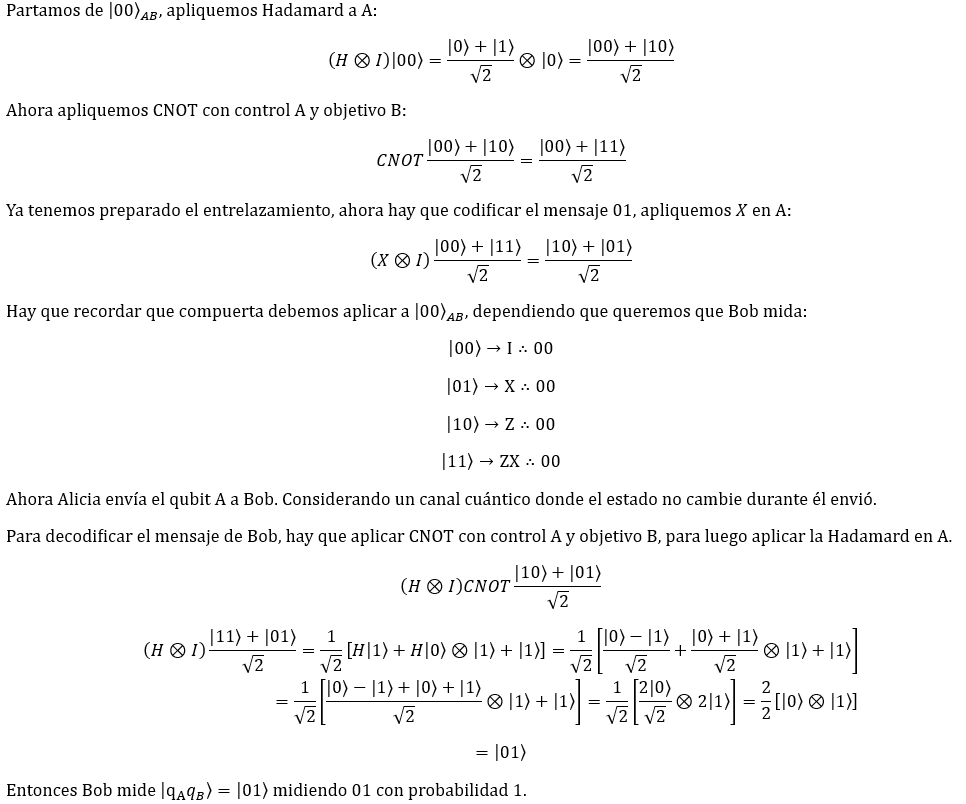